In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import keras
from keras.utils import multi_gpu_model
import tensorflow as tf
from temnn.knet import net
from temnn.net.dataset import DataEntry,DataSet
from temnn.net.mods import local_normalize
from pyqstem.imaging import CTF
import matplotlib.pyplot as plt
# Peak detection
from stm.preprocess import normalize
from stm.feature.peaks import find_local_peaks, refine_peaks
from skimage.morphology import disk
from scipy.spatial import cKDTree as KDTree
import sys
import os
from collections import deque
import hyperspy.api as hs
import skimage.io
import skimage.color

Using TensorFlow backend.


In [4]:
graph_dir = 'graphs-110-dosequickB'
graph_path = os.path.join(graph_dir, 'clusters-4.h5')

In [5]:
def load_CNN(graph_path, size, num_gpus=1):
    "Load the Keras neural net, and return a Model."
    kernel_num=32
    image_features=1
    num_classes=1

    if num_gpus == 1:
        x = keras.Input(shape=size+(image_features,))
        model = net.graph(x, output_features=num_classes)
        model.load_weights(graph_path)
    else:
        with tf.device('/cpu:0'):
            x = keras.Input(shape=size+(image_features,))
            model = net.graph(x, output_features=num_classes)
            model.load_weights(graph_path)
        model = multi_gpu_model(model, gpus=num_gpus)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    
    return (x, model)

In [6]:
if True:
    d = 'exp_data/Au-NP-01--412_09nm_crop/Hour_00/Minute_00/Second_00/'
    f = 'Au-NP-01--412_09nm_crop_Hour_00_Minute_00_Second_00_Frame_0000.dm4'
    a = hs.load(d+f)
    image = a.data
else:
    f = 'experiment/Au-CeO2__200_CO_7_250/frame00001.png'
    a = skimage.io.imread(f)
    image = skimage.color.rgb2gray(a)
    image = skimage.transform.rescale(image, 2.4, multichannel=False)
image_size = image.shape
print(image_size)
# Must be divisible by 8
image_size = tuple(np.array(image_size) // 8 * 8)
print(image_size)
image = image[:image_size[0],:image_size[1]]
print(image.shape, image.dtype)

(844, 844)
(840, 840)
(840, 840) float32


In [7]:
# Find the latest CNN
print("Looking for CNNs in files matching", graph_path)
gr = graph_path
print("Using CNN parameters in", gr)
x, model = load_CNN(gr, image_size, 1)

Looking for CNNs in files matching graphs-110-dosequickB/clusters-4.h5
Using CNN parameters in graphs-110-dosequickB/clusters-4.h5


In [8]:
img2 = local_normalize(image, 120, 120)

In [9]:
img2.shape, img2.max(), img2.min()

((840, 840), 5.3116574, -3.90167)

In [10]:
img2.shape = (1, ) + image_size + (1,)
predictions = model.predict(img2)

Find the peaks in the output from the CNN

In [12]:
resolution = 0.087
peaks = find_local_peaks(predictions[0,:,:,0], min_distance=2.5/resolution,
                         threshold=0.5, exclude_border=10,
                         exclude_adjacent=True)
peaks = refine_peaks(normalize(predictions[0,:,:,0]), peaks, 
                               disk(2), model='polynomial')

Saved


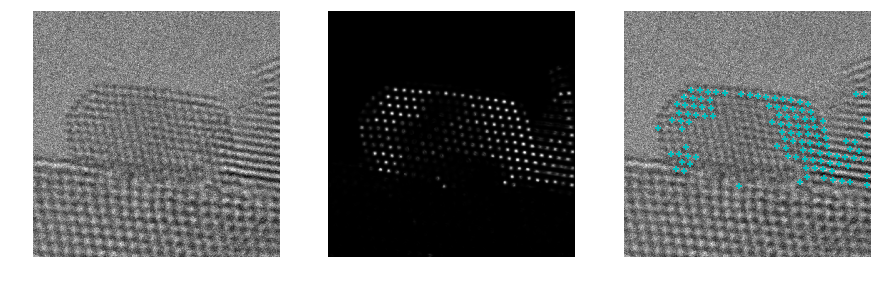

In [18]:
ig, (ax_raw, ax_pred, ax_atoms) = plt.subplots(1,3,figsize=(15,5))
im1 = ax_raw.imshow(image,cmap='gray')
#im2 = ax2.imshow(img2[0,:,:,0].T,cmap='gray')
im2 = ax_pred.imshow(predictions[0,:,:,0],cmap='gray')   
im3 = ax_atoms.imshow(image, cmap='gray')
ax_atoms.scatter(peaks[:,1], peaks[:,0], c='c', marker='+', linewidth=2.0)
ax_raw.axis('off')
ax_pred.axis('off')
ax_atoms.axis('off')
#plt.savefig("myimage.png")
#print("Saved")